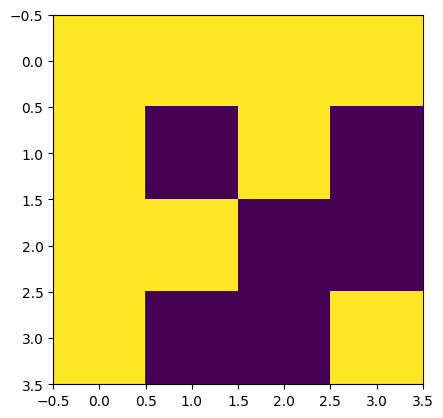

Starting global search over candidate sequences...
Trying candidate sequences with 5 pulses...
Found a candidate with 5 pulses, cost = 6.68e-08

Optimized pulse sequence (with optimized fractions and phases):
Pulse 1: coupling = (0, 3), fraction = 1.5000, phase = 0.5000
Pulse 2: coupling = (0, 2), fraction = 0.3918, phase = 1.5000
Pulse 3: coupling = (0, 1), fraction = 0.6667, phase = 1.5000
Pulse 4: coupling = (0, 2), fraction = 0.3918, phase = 1.5000
Pulse 5: coupling = (0, 3), fraction = 0.5000, phase = 0.5000

Target unitary (rounded):
[[ 0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]

Optimized sequence unitary (rounded):
[[ 0.5-0.j  0.5-0.j  0.5-0.j  0.5-0.j]
 [ 0.5+0.j -0.5-0.j  0.5+0.j -0.5+0.j]
 [ 0.5+0.j  0.5-0.j -0.5-0.j -0.5+0.j]
 [ 0.5+0.j -0.5-0.j -0.5-0.j  0.5-0.j]]


In [347]:
import numpy as np
import itertools
from scipy.linalg import expm
from scipy.optimize import minimize

# -----------------------------
# Parameters and Target Unitary
# -----------------------------
dim = 4

def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi):

    theta = np.pi * f      # rotation angle
    phi_rad = np.pi * phi  # effective phase in radians
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    # The pulse Hamiltonian is 0.5 * H (since our original code used that convention)
    U = expm(-1j * 0.5 * H * theta)
    return U

def candidate_unitary(seq, x):

    U = np.eye(dim, dtype=complex)
    k = len(seq)
    for i in range(k):
        f = x[2*i]
        phi = x[2*i+1]
        U_i = pulse_operator(seq[i], f, phi)
        U = U_i @ U
    return U

def optimal_global_phase(U, U_target):

    theta_opt = np.angle(np.trace(U @ np.conjugate(U_target).T))
    return theta_opt

def cost_function(x, seq, U_target):

    U = candidate_unitary(seq, x)
    theta_opt = optimal_global_phase(U, U_target)
    U_adjusted = np.exp(-1j * theta_opt) * U
    cost = np.linalg.norm(U_adjusted - U_target, ord='fro')
    return cost


couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
          + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
          + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
          + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
          + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1,1]+[1,1]+[1,1]+[1,1]\
           +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
                   +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
                   + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]


def canonicalize(coupling, phase_flag):

    i, j = coupling
    if i != 0 and j == 0:
        return (0, i), phase_flag + 1.0
    else:
        return coupling, phase_flag

# Build the full pulse list in canonical form.
# pulses_full = []
# for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
#     cpl_fixed, ph_fixed = canonicalize(cpl, ph)
#     pulses_full.append((cpl_fixed, frac, ph_fixed))

# U_target = np.eye(dim, dtype=complex)
# for (cpl, frac, ph) in pulses_full:
#     U_pulse = pulse_operator(cpl, frac, ph)
#     U_target = U_pulse @ U_target

# target = np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
#    0.354+0.j,  0.354+0.j,  0.354+0.j],
#  [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
#   -0.354-0.j,  0.354+0.j, -0.354-0.j],
#  [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
#    0.354+0.j, -0.354-0.j, -0.354-0.j],
#  [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
#   -0.354-0.j, -0.354-0.j,  0.354+0.j],
#  [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
#   -0.354-0.j, -0.354-0.j, -0.354-0.j],
#  [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
#    0.354+0.j, -0.354-0.j,  0.354+0.j],
#  [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
#   -0.354+0.j,  0.354+0.j, 0.354+0.j],
#  [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
#    0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex)

target = np.array([
    [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
    [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
    [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
    [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
], dtype=complex)

plt.figure()
plt.imshow(np.real(target))
plt.show()
U_target = target / np.linalg.det(target)

distinct_couplings = [(0,1), (0,2), (0,3)]

# We now search for a candidate sequence with k pulses (k = 1,2,..., k_max)
# that can produce U_target by adjusting the fractions and phases.
k_max = 5
threshold = 1e-6
best_seq = None
best_k = None
best_params = None
best_cost = None
cds = [[(0,3),(0,2),(0,1),(0,2),(0,3)]]
print("Starting global search over candidate sequences...")
for k in range(5, k_max+1):
    print(f"Trying candidate sequences with {k} pulses...")
    # Iterate over all sequences (with repetition) of length k from distinct_couplings.
    for seq in cds:#itertools.product(distinct_couplings, repeat=k):
        # Use multiple random initial guesses to optimize the continuous parameters.
        success_found = False
        for trial in range(10):
            # x has 2*k parameters: for each pulse, fraction f and phase phi.
            # We'll initialize f in [0,1] and phi in [0,2].
            x0 = []
            for i in range(k):
                x0.append(np.random.uniform(0, 1))   # fraction f
                x0.append(np.random.uniform(0, 2))   # phase phi
            x0 = np.array(x0)
            # Bounds: allow fraction to vary in [0, 1.5] and phase in [0, 2].
            bounds = []
            for i in range(k):
                bounds.append((0, 2))  # fraction bounds
                bounds.append((0, 2))    # phase bounds
            res = minimize(cost_function, x0, args=(seq, U_target), method='L-BFGS-B', bounds=bounds,
                           options={'ftol': 1e-12, 'gtol': 1e-12, 'maxiter':1000})
            if res.success and res.fun < threshold:
                best_seq = seq
                best_k = k
                best_params = res.x
                best_cost = res.fun
                success_found = True
                print(f"Found a candidate with {k} pulses, cost = {best_cost:.2e}")
                break  # break out of the trial loop
        if success_found:
            break  # break out of the candidate sequence loop for this k
    if best_seq is not None:
        break  # stop increasing k once a candidate is found

if best_seq is not None:
    print("\nOptimized pulse sequence (with optimized fractions and phases):")
    for i, coupling in enumerate(best_seq):
        f_val = best_params[2*i]
        phi_val = best_params[2*i+1]
        print(f"Pulse {i+1}: coupling = {coupling}, fraction = {f_val:.4f}, phase = {phi_val:.4f}")
    U_optimized = candidate_unitary(best_seq, best_params)
    theta_opt = optimal_global_phase(U_optimized, U_target)
    U_adjusted = np.exp(-1j*theta_opt) * U_optimized
    print("\nTarget unitary (rounded):")
    print(np.round(U_target, 3))
    print("\nOptimized sequence unitary (rounded):")
    print(np.round(U_adjusted, 3))
else:
    print("No sequence found with fewer pulses that approximates the target unitary within the threshold.")


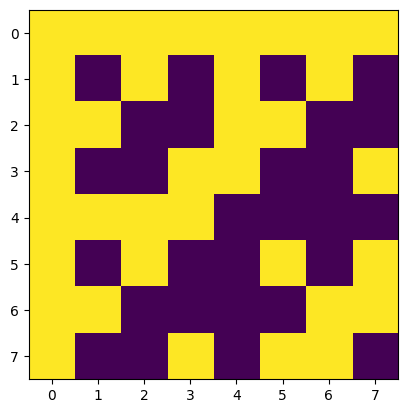

In [97]:
target = np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex)
plt.figure()
plt.imshow(np.real(target))
plt.show()

In [93]:
x = np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]])

In [327]:
couplings = []
fractions = []
fixed_phase_flags = []
for i, coupling in enumerate(best_seq):
    couplings.append(coupling)
    fractions.append(best_params[2*i])
    fixed_phase_flags.append(best_params[2*i+1])
    f_val = best_params[2*i]
    phi_val = best_params[2*i+1]
    print(f"Pulse {i+1}: coupling = {coupling}, fraction = {f_val:.4f}, phase = {phi_val:.4f}")

Pulse 1: coupling = (0, 3), fraction = 0.5000, phase = 1.5000
Pulse 2: coupling = (0, 2), fraction = 0.3918, phase = 0.5000
Pulse 3: coupling = (0, 1), fraction = 0.6667, phase = 0.5000
Pulse 4: coupling = (0, 2), fraction = 0.3918, phase = 0.5000
Pulse 5: coupling = (0, 3), fraction = 1.5000, phase = 1.5000


In [329]:
print(couplings)
print(fractions)
print(fixed_phase_flags)

[(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)]
[0.4999999966335269, 0.3918265544225571, 0.6666666651000748, 0.3918265438720865, 1.4999999939034658]
[1.499999983924429, 0.49999998612735697, 0.4999999838487718, 0.49999998492558784, 1.499999984319494]


Using fixed_phase_flags: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

Target Walsh-Hadamard Matrix (H8/sqrt(8))
[[ 0.354  0.354  0.354  0.354  0.354  0.354  0.354  0.354]
 [ 0.354 -0.354  0.354 -0.354  0.354 -0.354  0.354 -0.354]
 [ 0.354  0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354]
 [ 0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354  0.354]
 [ 0.354  0.354  0.354  0.354 -0.354 -0.354 -0.354 -0.354]
 [ 0.354 -0.354  0.354 -0.354 -0.354  0.354 -0.354  0.354]
 [ 0.354  0.354 -0.354 -0.354 -0.354 -0.354  0.354  0.354]
 [ 0.354 -0.354 -0.354  0.354 -0.354  0.354  0.354 -0.354]]

Starting optimization...

Optimization successful!
Final cost (Frobenius norm squared): 8.696

Optimized fractions (theta/pi):
[1.3224 2.     1.7758 1.5086 1.6693 0.     0.6609 0.9686 1.5039 0.4023
 2.     1.5241 2.    ]

Optimized Unitary (rounded):
[[-0.073-0.j  0.018-0.j  0.42 -0.j  0.366-0.j  0.448-0.j  0.055-0.j
   0.68 -0.j  0.132-0.j]
 [ 0.244+0.j  0.508+0.j  0.   +0.j -0.428+0.j  0

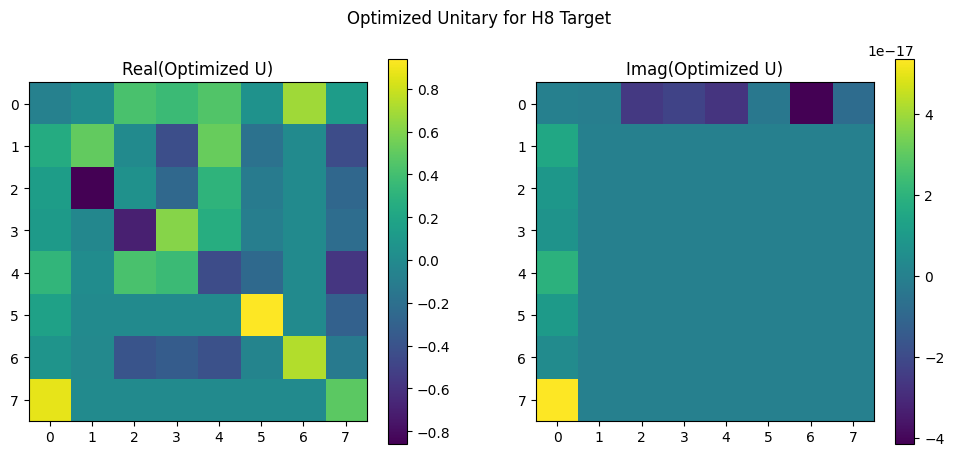

In [332]:
import numpy as np
from scipy.linalg import expm, hadamard
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- Functions (copied from your example) ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega) # t_pulse is theta/Omega
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

# --- Optimization Setup ---
dim = 8
num_rotations = 13

# Fixed parameters based on your desired sequence
couplings = [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), \
             (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]
rabi_freqs = np.ones(num_rotations)

# --- Choose Fixed Phases (Hypothesis) ---
# Option 1: Keep the [1.5, 0.5, ..., 0.5, 1.5] pattern
# fixed_phase_flags = [1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, \
#                      0.5, 0.5, 0.5, 0.5, 0.5, 1.5]
# Option 2: Try all 0.5 (pi/2) - This might be more Hadamard-like
fixed_phase_flags = [0.5] * num_rotations
# Option 3: Try optimizing phases too (more complex - start by fixing them)

print(f"Using fixed_phase_flags: {fixed_phase_flags}")

# --- Target Matrix ---
H_target = hadamard(dim) / np.sqrt(dim)
print("\nTarget Walsh-Hadamard Matrix (H8/sqrt(8))")
print(np.round(H_target, 3))

# --- Cost Function (Optimizing Fractions) ---
# We want to minimize the distance between the generated U and H_target
def cost_function(fractions_flat):
    # Ensure fractions are within reasonable bounds if needed (handled by optimizer bounds)
    # fractions_flat = np.clip(fractions_flat, 0, 2) # Example clipping if needed

    current_U = unitary(couplings, rabi_freqs, fractions_flat, fixed_phase_flags, dim)

    # Cost: Frobenius norm squared distance (aim for 0)
    cost = np.linalg.norm(current_U - H_target, 'fro')**2

    # Optional: Add a penalty if U is not unitary (should be unitary by construction)
    # non_unitary_penalty = np.linalg.norm(current_U @ current_U.conj().T - np.eye(dim), 'fro')**2
    # cost += 10 * non_unitary_penalty # Add penalty with a weight

    return cost

# --- Initial Guess and Bounds for Fractions ---
# Use the previously extrapolated values as a starting point, or simpler ones like 0.5
asin = np.arcsin; pi = np.pi; sqrt = np.sqrt
initial_fractions_extrapolated = [
    0.5, 2*asin(sqrt(1/3))/pi, 1/3, 2*asin(sqrt(1/5))/pi, 2*asin(sqrt(1/6))/pi,
    2*asin(sqrt(1/7))/pi, 2*asin(sqrt(7/8))/pi, 2*asin(sqrt(1/7))/pi,
    2*asin(sqrt(1/6))/pi, 2*asin(sqrt(1/5))/pi, 1/3, 2*asin(sqrt(1/3))/pi, 1.5
]
initial_guess = np.array(initial_fractions_extrapolated)
# Or a simpler guess:
# initial_guess = np.full(num_rotations, 0.5)

# Bounds for fractions (e.g., 0 to 2 allows angles 0 to 2*pi)
bounds = [(0, 2)] * num_rotations

# --- Run Optimization ---
print("\nStarting optimization...")
# Methods to try: 'L-BFGS-B', 'SLSQP', 'TNC', 'Nelder-Mead' (Nelder-Mead doesn't use bounds)
result = minimize(cost_function, initial_guess, method='L-BFGS-B', bounds=bounds,
                  options={'disp': True, 'maxiter': 1500, 'ftol': 1e-10, 'gtol': 1e-7})

# --- Analyze Result ---
if result.success:
    optimized_fractions = result.x
    final_cost = result.fun
    print("\nOptimization successful!")
    print(f"Final cost (Frobenius norm squared): {final_cost:.4g}") # Should be close to 0

    print("\nOptimized fractions (theta/pi):")
    print(np.round(optimized_fractions, 4))

    # Verify the result
    U_optimized = unitary(couplings, rabi_freqs, optimized_fractions, fixed_phase_flags, dim)
    print("\nOptimized Unitary (rounded):")
    print(np.round(U_optimized, 3))

    print("\nTarget Unitary (rounded, for comparison):")
    print(np.round(H_target, 3))

    # Check how close it is (Trace overlap should be close to 1)
    trace_overlap = np.abs(np.trace(H_target.conj().T @ U_optimized)) / dim
    print(f"\nTrace overlap |Tr(H_target* U_opt)|/d: {trace_overlap:.6f}")

    # Visualize
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.real(U_optimized), cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title("Real(Optimized U)")
    plt.subplot(1, 2, 2)
    plt.imshow(np.imag(U_optimized), cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title("Imag(Optimized U)")
    plt.suptitle("Optimized Unitary for H8 Target")
    plt.show()

else:
    print("\nOptimization failed:", result.message)
    print("Final cost:", result.fun)
    # Try different initial guesses, bounds, methods, or optimize phases too.

In [232]:
import sympy as sp
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt
import warnings

# --- Helper functions (keep as they are) ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi*np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

# --- Symbolic Givens Rotation ---
def givens_rotation_symbolic(i, j, theta, phi, dim):
    G = sp.eye(dim)
    cos_term = sp.cos(theta / 2)
    sin_term = sp.sin(theta / 2)
    e_neg_iphi = sp.exp(-sp.I * phi)
    e_pos_iphi = sp.conjugate(e_neg_iphi)

    G[i, i] = cos_term
    G[j, j] = cos_term
    G[i, j] = -sp.I * e_pos_iphi * sin_term
    G[j, i] = -sp.I * e_neg_iphi * sin_term
    return G

# --- Main Script for Simplified nsolve Test ---

# Dimension
dim = 4

# == Define Symbolic Structure (Single Pulse) ==
# We expect to recover the params for the first pulse (0, 3)
sequence = [(0, 3)]
num_pulses = len(sequence)
i_idx, j_idx = sequence[0] # Get indices for equation setup

# Define symbolic parameters (theta_0, phi_0)
params = [sp.symbols('theta_0', real=True), sp.symbols('phi_0', real=True)]
theta_0, phi_0 = params
print(f"Symbolic parameters to solve for: {params}")

# Build the symbolic unitary (just one rotation)
U_symbolic = givens_rotation_symbolic(i_idx, j_idx, theta_0, phi_0, dim)
print("\nSymbolic Unitary (Structure):")
sp.pprint(U_symbolic)


# --- Generate the Target Unitary (Single Pulse) ---
target_couplings = [(0, 3)]
target_fractions = np.array([0.5]) # First fraction
target_fixed_phase_flags = np.array([1.5]) # First phase flag
target_rabi_freqs = np.array([1])

# Apply fixing (although for (0,3) it won't change anything)
target_couplings_fixed, target_fixed_phase_flags_fixed = fix_couplings_and_phases(
    target_couplings, target_fixed_phase_flags
)

# Calculate expected parameters (for verification and initial guess)
expected_theta_0 = target_fractions[0] * np.pi
expected_phi_0 = target_fixed_phase_flags_fixed[0] * np.pi
print(f"\nExpected theta_0 = pi * fraction = {expected_theta_0:.4f} ({target_fractions[0]}*pi)")
print(f"Expected phi_0 = pi * fixed_phase_flag = {expected_phi_0:.4f} ({target_fixed_phase_flags_fixed[0]}*pi)")


# Generate the target U using the original method but only the first pulse data
target_U = unitary(target_couplings_fixed,
                   target_rabi_freqs,
                   target_fractions,
                   target_fixed_phase_flags_fixed,
                   dim)

print("\nTarget Unitary (Numeric, Rounded):")
print(np.round(target_U, 3))
target_U_sym = sp.Matrix(target_U) # Convert to sympy Matrix for equations

# --- Set up Equations for nsolve (N equations for N unknowns) ---
# We need 2 equations for 2 unknowns (theta_0, phi_0).
# Let's use the real part of the diagonal element and the imaginary part of the off-diagonal.
# Equations are expression = 0
eq1 = sp.re(U_symbolic[i_idx, i_idx]) - sp.re(target_U_sym[i_idx, i_idx])
eq2 = sp.im(U_symbolic[i_idx, j_idx]) - sp.im(target_U_sym[i_idx, j_idx])
equations = [eq1, eq2]

print("\nEquations for nsolve:")
sp.pprint(equations[0])
print("= 0")
sp.pprint(equations[1])
print("= 0")

# --- Define Initial Guesses ---
# Use values slightly perturbed from the expected ones
guess_theta_0 = expected_theta_0 * 0.01 # e.g., 0.4*pi instead of 0.5*pi
guess_phi_0 = expected_phi_0 * 0.01 # e.g., 1.65*pi instead of 1.5*pi
initial_guesses = [guess_theta_0, guess_phi_0]
print(f"\nInitial Guesses: {initial_guesses}")

# --- Solve Numerically using nsolve ---
print("\nAttempting to solve numerically using nsolve...")
try:
    # nsolve requires equations, variables, and initial guesses
    solutions_nsolve = sp.nsolve(equations, params, initial_guesses)

    print("\nNumerical Solution Found:")
    # nsolve returns a Matrix object
    solved_theta_0 = solutions_nsolve[0,0]
    solved_phi_0 = solutions_nsolve[1,0]
    print(f"  theta_0 = {solved_theta_0}")
    print(f"  phi_0 = {solved_phi_0}")

    # Compare with expected values
    print("\nComparison with Expected Values:")
    print(f"  theta_0 Error: {abs(solved_theta_0 - expected_theta_0)}")
    # For phase, consider modulo 2*pi differences
    phi_diff = abs(solved_phi_0 - expected_phi_0)
    phi_diff_mod = abs( (solved_phi_0 - expected_phi_0 + np.pi) % (2*np.pi) - np.pi ) # More robust comparison
    print(f"  phi_0 Error: {phi_diff}")
    print(f"  phi_0 Error (mod 2pi): {phi_diff_mod}")


    # --- Verification ---
    print("\nVerifying solution:")
    sub_dict = {params[0]: solved_theta_0, params[1]: solved_phi_0}
    U_check_sym = U_symbolic.subs(sub_dict)

    # Convert symbolic matrix with numbers to numpy array
    try:
        U_check_np = np.array(U_check_sym.tolist(), dtype=complex)
        print("Symbolic U evaluated with nsolve solution (Rounded):")
        print(np.round(U_check_np, 3))

        print("\nDifference between Target U and Calculated U (Magnitude):")
        diff_mag = np.abs(target_U - U_check_np)
        print(np.round(diff_mag, 5))
        print(f"Max difference: {np.max(diff_mag)}")
        print(f"Matrices are close: {np.allclose(target_U, U_check_np)}")

    except Exception as e:
        print(f"Could not convert solution matrix to numpy: {e}")

except (NotImplementedError, TypeError) as e:
    print(f"\nSolver failed: {e}")
    print("Check equations, variable types, and initial guesses.")
except ValueError as e:
     print(f"\nSolver failed: {e}")
     print("This often happens if the solver cannot find a solution from the initial guess.")
except Exception as e:
    print(f"\nAn unexpected error occurred during solving: {e}")

ValueError: too many values to unpack (expected 2)

In [364]:
import sympy as sp
from scipy.linalg import expm
import numpy as np
import warnings

# --- Helper functions (keep as they are) ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * f
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        H_op = coupling_operator_with_phase(i, j, dim, phi_fixed)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

# --- Symbolic Givens Rotation ---
def givens_rotation_symbolic(i, j, theta, phi, dim):
    G = sp.eye(dim)
    cos_term = sp.cos(theta / 2)
    sin_term = sp.sin(theta / 2)
    e_neg_iphi = sp.exp(-sp.I * phi)
    e_pos_iphi = sp.conjugate(e_neg_iphi)

    G[i, i] = cos_term
    G[j, j] = cos_term
    G[i, j] = -sp.I * e_pos_iphi * sin_term
    G[j, i] = -sp.I * e_neg_iphi * sin_term
    return G

# --- Main Script for Multi-Pulse nsolve Test ---

# Dimension
dim = 4

# Define sequence parameters
couplings = [(0, 3)]#, (0, 1)]#, (0, 2), (0, 1), (0, 3)]
fractions = [
    0.5
    # 2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
    # 4/3,
    # 2.0 * np.arcsin(np.sqrt(2/3)) / np.pi + 1,
    # 0.5
]
fixed_phase_flags = [1.5]#, 0.5, 1.5, 0.5, 0.5]
rabi_freqs = [1] * len(couplings)

# Apply fixing (for couplings and phases)
couplings_fixed, fixed_phase_flags_fixed = fix_couplings_and_phases(
    couplings, fixed_phase_flags
)

num_pulses = len(couplings_fixed)

# Create symbolic parameters: theta_0..theta_{num_pulses-1}, phi_0..phi_{num_pulses-1}
theta_syms = sp.symbols(f'theta_0:{num_pulses}', real=True)
phi_syms = sp.symbols(f'phi_0:{num_pulses}', real=True)
params = list(theta_syms) + list(phi_syms)

# Build the symbolic unitary for the full sequence
U_symbolic = sp.eye(dim)
for k, levels in enumerate(couplings_fixed):
    i, j = levels
    theta_k = theta_syms[k]
    phi_k = phi_syms[k]
    G_k = givens_rotation_symbolic(i, j, theta_k, phi_k, dim)
    U_symbolic = G_k @ U_symbolic

# Generate the target U numerically
target_U = unitary(
    couplings_fixed,
    rabi_freqs,
    fractions,
    fixed_phase_flags_fixed,
    dim
)
target_U_sym = sp.Matrix(target_U)

# Setup equations: match real parts of diagonal and imaginary parts of selected off-diagonals
equations = []
# Real(diag) = Real(target diag)
for idx in range(dim):
    equations.append(sp.re(U_symbolic[idx, idx]) - sp.re(target_U_sym[idx, idx]))
# Imag parts of some off-diagonals
off_diag_idxs = [(0,3)]#, (0,1), (0,2), (0,1), (0,3)]
for (i,j) in off_diag_idxs:
    equations.append(sp.im(U_symbolic[i, j]) - sp.im(target_U_sym[i, j]))
# Add one more equation to reach 2*num_pulses = 10
equations.append(sp.im(U_symbolic[1, 2]) - sp.im(target_U_sym[1, 2]))

# Define initial guesses based on expected values
expected_thetas = [f * np.pi for f in fractions]
expected_phis = [pf * np.pi for pf in fixed_phase_flags_fixed]
initial_guesses = [et * 0.1 for et in expected_thetas] + [ep * 0.1 for ep in expected_phis]

# Solve numerically with nsolve
print("Solving for symbolic parameters...")
sol = sp.nsolve(
    equations,
    params,
    initial_guesses,
    # tol=1e-14,
    # maxsteps=50,
    # prec=30     
)

# Display solutions
for k in range(num_pulses):
    print(f"theta_{k} =", solutions[k]/np.pi)
    print(f"phi_{k}   =", solutions[num_pulses + k]/np.pi)


Solving for symbolic parameters...
theta_0 = 48303.6671440842
phi_0   = -227851.000000350


In [298]:
import sympy as sp
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time # To time the solver

# --- Helper functions (keep as they are) ---
def coupling_operator_with_phase(i, j, dim, phi):
    # ... (same as before)
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    # ... (same as before)
    theta = np.pi*np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    # ... (same as before)
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    # ... (same as before)
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

# --- Symbolic Givens Rotation ---
def givens_rotation_symbolic(i, j, theta, phi, dim):
    # ... (same as before)
    G = sp.eye(dim)
    cos_term = sp.cos(theta / 2)
    sin_term = sp.sin(theta / 2)
    e_neg_iphi = sp.exp(-sp.I * phi)
    e_pos_iphi = sp.conjugate(e_neg_iphi)

    G[i, i] = cos_term
    G[j, j] = cos_term
    G[i, j] = -sp.I * e_pos_iphi * sin_term
    G[j, i] = -sp.I * e_neg_iphi * sin_term
    return G

# --- Main Script for Full Sequence nsolve Test ---

# Dimension
dim = 4

# == Define Symbolic Structure (Full Sequence) ==
# Use the original couplings structure to define the sequence of variables
# The actual coupling values (indices) for symbolic U will come from the *fixed* list
original_couplings = [(0, 3), (0, 1)]#, (0, 2), (0, 1), (0, 3)]
original_fixed_phase_flags = [1.5, 0.5]#, 1.5, 0.5, 0.5] # Example values, needed for fixing structure
num_pulses = len(original_couplings)

# Get the actual sequence structure AFTER fixing
sequence_struct, _ = fix_couplings_and_phases(
    original_couplings, original_fixed_phase_flags
)
print(f"Symbolic sequence structure (couplings): {sequence_struct}")
if len(sequence_struct) != num_pulses:
     warnings.warn("Mismatch in length after fixing - check logic.")


# Define symbolic parameters (theta_0..4, phi_0..4)
params = []
for k in range(num_pulses):
    theta = sp.symbols(f'theta_{k}', real=True) # Represents pi * fraction_k
    phi = sp.symbols(f'phi_{k}', real=True)     # Represents pi * fixed_phase_flag_k
    params.extend([theta, phi])

print(f"\nSymbolic parameters to solve for ({len(params)}): {params}")

# Build the full symbolic unitary U = G_N * ... * G_0
print("\nBuilding full symbolic unitary (this might take a moment)...")
start_build_time = time.time()
U_symbolic = sp.eye(dim)
for k, (i, j) in enumerate(sequence_struct):
    theta_k = params[2*k]
    phi_k = params[2*k+1]
    Gk = givens_rotation_symbolic(i, j, theta_k, phi_k, dim)
    U_symbolic = Gk * U_symbolic # Apply k-th pulse from the left
end_build_time = time.time()
print(f"Symbolic unitary built in {end_build_time - start_build_time:.2f} seconds.")
# print("\nSymbolic Unitary (Structure - showing only U[0,0]):") # Printing the whole thing is too much
# sp.pprint(U_symbolic[0,0])


# --- Generate the Target Unitary (Full Sequence) ---
target_couplings = [(0, 3), (0, 1)]#, (0, 2), (0, 1), (0, 3)]
target_fractions = np.array([0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1, 0.5])
target_fixed_phase_flags = np.array([1.5, 0.5, 1.5, 0.5, 0.5])
target_rabi_freqs = np.array([1,1,1,1,1]) # Needed for 'unitary' function

# Apply fixing *before* generating target
target_couplings_fixed, target_fixed_phase_flags_fixed = fix_couplings_and_phases(
    target_couplings, target_fixed_phase_flags
)
# Ensure the structure used for target matches the symbolic sequence
if target_couplings_fixed != sequence_struct:
    warnings.warn("Mismatch between target generation couplings and symbolic sequence structure!")
    print("Target uses:", target_couplings_fixed)
    print("Symbolic uses:", sequence_struct)


# Calculate expected parameters (for verification and initial guess)
expected_thetas = target_fractions * np.pi
expected_phis = target_fixed_phase_flags * np.pi
expected_params = []
print("\nExpected Parameters (Numeric):")
for k in range(num_pulses):
    print(f"  theta_{k}: {expected_thetas[k]:.4f}, phi_{k}: {expected_phis[k]:.4f}")
    expected_params.extend([expected_thetas[k], expected_phis[k]])


# Generate the target U using the original method with the full sequence
target_U = unitary(target_couplings_fixed,
                   target_rabi_freqs,
                   target_fractions,
                   target_fixed_phase_flags_fixed,
                   dim)

print("\nTarget Unitary (Numeric, Rounded):")
print(np.round(target_U, 3))
target_U_sym = sp.Matrix(target_U) # Convert to sympy Matrix for equations

# --- Set up Equations for nsolve (N equations for N unknowns) ---
# Need 10 equations for 10 unknowns. Let's use Re/Im parts of:
# U[0,0], U[0,1], U[0,2], U[0,3], U[1,0]
equations = []
elements_to_use = [(0, 3), (0, 1)]#, (0, 2), (0, 1), (0, 3)]

print("\nSelecting equations from elements:", elements_to_use)
for i, j in elements_to_use:
    diff = U_symbolic[i, j] - target_U_sym[i, j]
    equations.append(sp.re(diff))
    equations.append(sp.im(diff))

print(f"Generated {len(equations)} equations for {len(params)} unknowns.")
if len(equations) != len(params):
     raise ValueError("Number of equations does not match number of parameters!")

# --- Define Initial Guesses ---
# Use values slightly perturbed from the expected ones
initial_guesses = [p * (1 + 0.1 * (np.random.rand() - 0.5)) for p in expected_params] # Perturb by up to +/- 5%
print(f"\nInitial Guesses (Perturbed): {np.round(initial_guesses, 4)}")

# --- Solve Numerically using nsolve ---
print("\nAttempting to solve numerically using nsolve...")
print("WARNING: This might take a significant amount of time!")
start_solve_time = time.time()
try:
    # nsolve requires equations, variables, and initial guesses
    # May need to adjust solver options like 'tol' or 'maxsteps' if it struggles
    # solutions_nsolve = sp.nsolve(equations, params, initial_guesses, prec=30) # Increase precision if needed
    solutions_nsolve = sp.nsolve(equations, params, initial_guesses)


    end_solve_time = time.time()
    print(f"nsolve finished in {end_solve_time - start_solve_time:.2f} seconds.")

    print("\nNumerical Solution Found:")
    # nsolve returns a Matrix object
    solved_params = solutions_nsolve.transpose().tolist()[0] # Extract solutions as a list

    print("\nComparison with Expected Values:")
    param_names = [str(p) for p in params]
    max_abs_error = 0
    max_mod_error = 0
    for k in range(len(params)):
        solved = solved_params[k]
        expected = expected_params[k]
        abs_error = abs(solved - expected)
        max_abs_error = max(max_abs_error, abs_error)
        print(f"  {param_names[k]:<8}: Solved={solved:<8.4f} Expected={expected:<8.4f} AbsError={abs_error:<.2e}", end="")

        # Check phase errors modulo 2*pi
        if 'phi' in param_names[k]:
             mod_error = abs( (solved - expected + np.pi) % (2*np.pi) - np.pi )
             max_mod_error = max(max_mod_error, mod_error)
             print(f" ModError={mod_error:<.2e}")
        else:
             print("") # newline for theta

    print(f"\nMax Absolute Parameter Error: {max_abs_error:.2e}")
    print(f"Max Phase Error (mod 2pi): {max_mod_error:.2e}")


    # --- Verification ---
    print("\nVerifying solution:")
    sub_dict = {p: val for p, val in zip(params, solved_params)}
    # Evaluating symbolic U with solved params can also be slow
    print("Evaluating symbolic U with solved parameters...")
    start_verify_time = time.time()
    U_check_sym = U_symbolic.subs(sub_dict)
    end_verify_time = time.time()
    print(f"Evaluation took {end_verify_time - start_verify_time:.2f} seconds.")

    # Convert symbolic matrix with numbers to numpy array
    try:
        U_check_np = np.array(U_check_sym.tolist()).astype(complex)
        print("\nSymbolic U evaluated with nsolve solution (Rounded):")
        print(np.round(U_check_np, 3))

        print("\nDifference between Target U and Calculated U (Magnitude):")
        diff_mag = np.abs(target_U - U_check_np)
        print(np.round(diff_mag, 5))
        max_diff = np.max(diff_mag)
        print(f"Max element-wise difference: {max_diff:.2e}")
        print(f"Matrices are close (tol=1e-5): {np.allclose(target_U, U_check_np, atol=1e-5)}") # Use tolerance

    except Exception as e:
        print(f"\nCould not convert solution matrix to numpy: {e}")
        print("This might happen if the solution contains symbolic constants (like pi).")


except (NotImplementedError, TypeError) as e:
    print(f"\nSolver failed: {e}")
    print("The symbolic expressions might be too complex, or there might be type issues.")
except ValueError as e:
     print(f"\nSolver failed: {e}")
     print("This often happens if the solver cannot find a solution from the initial guess.")
     print("Try different initial guesses or equation selections.")
except Exception as e:
    print(f"\nAn unexpected error occurred during solving: {e}")

print("\n--- Script Finished ---")

Symbolic sequence structure (couplings): [(0, 3), (0, 1)]

Symbolic parameters to solve for (4): [theta_0, phi_0, theta_1, phi_1]

Building full symbolic unitary (this might take a moment)...
Symbolic unitary built in 0.00 seconds.

Expected Parameters (Numeric):
  theta_0: 1.5708, phi_0: 4.7124
  theta_1: 1.2310, phi_1: 1.5708

Target Unitary (Numeric, Rounded):
[[ 0.577+0.j  0.577-0.j  0.   +0.j -0.577+0.j]
 [-0.408-0.j  0.816+0.j  0.   +0.j  0.408-0.j]
 [ 0.   +0.j  0.   +0.j  1.   +0.j  0.   +0.j]
 [ 0.707+0.j  0.   +0.j  0.   +0.j  0.707+0.j]]

Selecting equations from elements: [(0, 3), (0, 1)]
Generated 4 equations for 4 unknowns.

Initial Guesses (Perturbed): [1.5593 4.9039 1.2158 1.596 ]

Attempting to solve numerically using nsolve...
nsolve finished in 0.03 seconds.

Numerical Solution Found:

Comparison with Expected Values:

Solver failed: unsupported format string passed to Zero.__format__
The symbolic expressions might be too complex, or there might be type issues.

--- 

In [159]:
import numpy as np

def givens_rotation(i, j, theta, phi, dim):
    """Numerical Givens rotation acting on levels i and j."""
    G = np.eye(dim, dtype=complex)
    cos = np.cos(theta/2)
    sin = np.sin(theta/2)
    eiphase = np.exp(-1j * phi)
    
    # 2x2 block
    G_block = np.array([
        [cos, -1j*np.conj(eiphase) * sin],
        [-1j*eiphase * sin, cos]
    ])
    
    # Embed
    G[np.ix_([i, j], [i, j])] = G_block
    return G

# Given parameters
dim = 4
couplings = [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
fractions = [
    0.5,
    2.0 * np.arcsin(np.sqrt(1/3))/np.pi,
    4/3,
    2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1,
    0.5
]
fixed_phase_flags = [1.5, 0.5, 1.5, 0.5, 0.5]

# Target Hadamard-like matrix
target = np.array([
    [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
    [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
    [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
    [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
], dtype=complex)

# Build the unitary step-by-step
U = np.eye(dim, dtype=complex)
for k, (i, j) in enumerate(couplings):
    theta = np.pi * fractions[k]
    phi = np.pi * fixed_phase_flags[k]
    G = givens_rotation(i, j, theta, phi, dim)
    U = G @ U  # Left multiplication

# Now check
print("Constructed unitary:\n", np.round(U, 3))
print("\nTarget unitary:\n", np.round(target, 3))

# Check closeness
print("\nAre they close?:", np.allclose(U, target, atol=1e-6))


Constructed unitary:
 [[ 0.5+0.j  0.5-0.j  0.5-0.j  0.5-0.j]
 [ 0.5+0.j -0.5+0.j  0.5-0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]

Target unitary:
 [[ 0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]

Are they close?: True


Target Unitary (rounded):
[[ 1.        -0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j]
 [ 0.        +0.j  0.35355339-0.j  0.35355339-0.j  0.35355339-0.j
   0.35355339-0.j  0.35355339-0.j  0.35355339-0.j  0.35355339-0.j
   0.35355339-0.j]
 [ 0.        +0.j  0.35355339+0.j -0.35355339+0.j  0.35355339-0.j
  -0.35355339+0.j  0.35355339-0.j -0.35355339+0.j  0.35355339-0.j
  -0.35355339+0.j]
 [ 0.        +0.j  0.35355339+0.j  0.35355339-0.j -0.35355339+0.j
  -0.35355339+0.j  0.35355339-0.j  0.35355339-0.j -0.35355339+0.j
  -0.35355339+0.j]
 [ 0.        +0.j  0.35355339+0.j -0.35355339-0.j -0.35355339+0.j
   0.35355339-0.j  0.35355339-0.j -0.35355339+0.j -0.35355339+0.j
   0.35355339-0.j]
 [ 0.        +0.j  0.35355339+0.j  0.35355339-0.j  0.35355339-0.j
   0.35355339-0.j -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j
  -0.35355339+0.j]
 [ 0.        +0.j  0.35355339+0.j -0.35355339-0.j  0.35355339-0.j
  

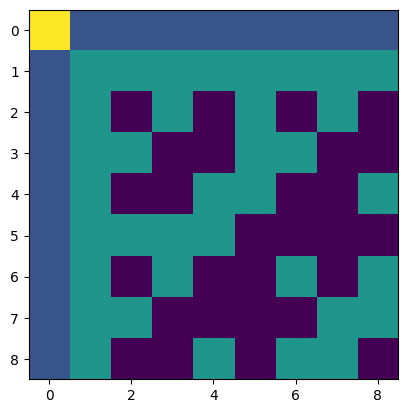

In [16]:
import numpy as np
import itertools
from scipy.linalg import expm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
###########################################
# Part 1: Build and output the target unitary
###########################################

dim = 9

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi):
    theta = np.pi * f      # rotation angle = π*f
    phi_rad = np.pi * phi  # effective phase (in radians)
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    # Using the convention with 0.5 factor
    U = expm(-1j * 0.5 * H * theta)
    return U

def canonicalize(coupling, phase_flag):
    """Bring a pulse to canonical form: if given as (i,0) with i != 0, swap to (0,i) and add 1.0 to the phase flag."""
    i, j = coupling
    if i != 0 and j == 0:
        return (0, i), phase_flag + 1.0
    else:
        return coupling, phase_flag

# --- Define the full (original) pulse list in canonical form ---
# (These are your full-set input values for dim = 9.)
couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)]  +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)] +
                  [(6,0),(0,5),(6,0)] +
                  [(8,0),(7,0)]  +
                  [(0,5),(7,0)] +
                  [(6,0)] +
                  [(0,2),(6,0)] +
                  [(5,0),(0,1),(5,0)] +
                  [(7,0),(0,3),(7,0)] +
                  [(0,4),(8,0)])

fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2, 1] +
                  [1/2, 1])

fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5])

# Build the canonical pulse list.
pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

# Compute the target unitary by applying the pulses in order.
U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph)
    U_target = U_pulse @ U_target

# Remove the overall global phase by normalizing the determinant.
U_target = U_target / np.linalg.det(U_target)

print("Target Unitary (rounded):")
a = np.round(U_target, 15)
a.tolist
print(a)
plt.imshow(np.real(U_target))


In [18]:
a

array([[ 1.        -0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.35355339-0.j,  0.35355339-0.j,
         0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j,
         0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j],
       [ 0.        +0.j,  0.35355339+0.j, -0.35355339+0.j,
         0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j,
        -0.35355339+0.j,  0.35355339-0.j, -0.35355339+0.j],
       [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
        -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j,
         0.35355339-0.j, -0.35355339+0.j, -0.35355339+0.j],
       [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
        -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j,
        -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j],
       [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
         0.35355339-0.j,  0.35355339-0.j, -0.353553

In [22]:
###########################################
# Part 2: Optimal Coupling Sequence Search
###########################################

# Functions for candidate sequence search
def candidate_unitary(seq, x):
    """
    Given a candidate sequence (a list of couplings) and parameters x (length 2*k),
    where for each pulse: x[2*i] = fraction f and x[2*i+1] = phase phi,
    compute the overall candidate unitary.
    """
    U = np.eye(dim, dtype=complex)
    k = len(seq)
    for i in range(k):
        f = x[2*i]
        phi = x[2*i+1]
        U_i = pulse_operator(seq[i], f, phi)
        U = U_i @ U
    return U

def optimal_global_phase(U, U_target):
    """
    Compute the global phase that minimizes the difference between U and U_target.
    """
    theta_opt = np.angle(np.trace(U @ np.conjugate(U_target).T))
    return theta_opt

def cost_function(x, seq, U_target):
    """
    Cost function defined as the Frobenius norm difference between the candidate unitary
    (after optimal global phase adjustment) and U_target.
    """
    U = candidate_unitary(seq, x)
    theta_opt = optimal_global_phase(U, U_target)
    U_adjusted = np.exp(-1j * theta_opt) * U
    return np.linalg.norm(U_adjusted - U_target, ord='fro')

# Available distinct couplings in canonical form for dim=9.
distinct_couplings = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8)]

candidate_seq = []

# Global search parameters
k_max = 18
threshold = 1e-6
best_seq = None
best_k = None
best_params = None
best_cost = None

if candidate_seq is not None:
    # --- Optimize the continuous parameters for the provided candidate sequence ---
    k = len(candidate_seq)
    print(f"Optimizing parameters for candidate sequence with {k} pulses...")
    success_found = False
    for trial in range(20):
        # Initialize parameters: fractions in [0,1] and phases in [0,2]
        x0 = []
        for i in range(k):
            x0.append(np.random.uniform(0, 2))
            x0.append(np.random.uniform(0, 2))
        x0 = np.array(x0)
        # Bounds: fraction in [0,1.5] and phase in [0,2]
        bounds = []
        for i in range(k):
            bounds.append((0, 2))
            bounds.append((0, 2))
        res = minimize(cost_function, x0, args=(candidate_seq, U_target), method='L-BFGS-B',
                       bounds=bounds, options={'ftol': 1e-12, 'gtol': 1e-12, 'maxiter':1000})
        if res.success and res.fun < threshold:
            best_seq = candidate_seq
            best_k = k
            best_params = res.x
            best_cost = res.fun
            success_found = True
            print(f"Found a candidate with {k} pulses, cost = {best_cost:.2e}")
            break
    if not success_found:
        print("The provided candidate sequence could not reach the target unitary within the threshold.")
else:
    # --- Global search over candidate sequences if no initial candidate was provided ---
    print("Starting global search over candidate sequences...")
    for k in range(15, k_max+1):
        print(f"Trying candidate sequences with {k} pulses...")
        for seq in itertools.product(distinct_couplings, repeat=k):
            success_found = False
            for trial in range(10):
                x0 = []
                for i in range(k):
                    x0.append(np.random.uniform(0, 2))
                    x0.append(np.random.uniform(0, 2))
                x0 = np.array(x0)
                bounds = []
                for i in range(k):
                    bounds.append((0, 2))
                    bounds.append((0, 2))
                res = minimize(cost_function, x0, args=(seq, U_target), method='L-BFGS-B',
                               bounds=bounds, options={'ftol': 1e-12, 'gtol': 1e-12, 'maxiter':1000})
                if res.success and res.fun < threshold:
                    best_seq = seq
                    best_k = k
                    best_params = res.x
                    best_cost = res.fun
                    success_found = True
                    print(f"Found a candidate with {k} pulses, cost = {best_cost:.2e}")
                    break
            if success_found:
                break
        if best_seq is not None:
            break

if best_seq is not None:
    print("\nOptimized pulse sequence (with optimized fractions and phases):")
    for i, coupling in enumerate(best_seq):
        f_val = best_params[2*i]
        phi_val = best_params[2*i+1]
        print(f"Pulse {i+1}: coupling = {coupling}, fraction = {f_val:.4f}, phase = {phi_val:.4f}")
    U_optimized = candidate_unitary(best_seq, best_params)
    theta_opt = optimal_global_phase(U_optimized, U_target)
    U_adjusted = np.exp(-1j*theta_opt) * U_optimized
    print("\nTarget unitary (rounded):")
    print(np.round(U_target, 3))
    print("\nOptimized sequence unitary (rounded):")
    print(np.round(U_adjusted, 3))
else:
    print("No sequence found that approximates the target unitary within the threshold.")


Optimizing parameters for candidate sequence with 0 pulses...


ValueError: not enough values to unpack (expected 2, got 0)

In [8]:
import random

def construct_candidate_seq(distinct_couplings, shuffle_left=False):
    """
    Constructs a candidate sequence as follows:
    - left side: the first (n-1) couplings from distinct_couplings (n = len(distinct_couplings))
      (optionally shuffled),
    - center: the last coupling,
    - right side: mirror (reverse) of the left side.
    
    For distinct_couplings of length 8, the candidate sequence will have 2*8 - 1 = 15 couplings.
    """
    # Left couplings: take all but the last coupling.
    left = list(distinct_couplings[:-1])
    if shuffle_left:
        random.shuffle(left)
    center = distinct_couplings[-1]
    right = list(reversed(left))
    candidate_seq = left + [center] + right
    return candidate_seq

# Canonical candidate sequence using the order as provided:
distinct_couplings = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8)]
candidate_seq_canonical = construct_candidate_seq(distinct_couplings, shuffle_left=False)
print("Candidate sequence (canonical):")
print(candidate_seq_canonical)

# Optionally, if this candidate doesn't work, try shuffling the left side.
candidate_seq_shuffled = construct_candidate_seq(distinct_couplings, shuffle_left=True)
print("\nCandidate sequence (with shuffled left side):")
print(candidate_seq_shuffled)


Candidate sequence (canonical):
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1)]

Candidate sequence (with shuffled left side):
[(0, 1), (0, 3), (0, 6), (0, 5), (0, 2), (0, 7), (0, 4), (0, 8), (0, 4), (0, 7), (0, 2), (0, 5), (0, 6), (0, 3), (0, 1)]


In [10]:
import itertools

def all_candidate_sequences(distinct_couplings):
    """
    Generates all candidate sequences that meet the conditions:
      - Left side: a permutation of the first (n-1) couplings from distinct_couplings.
      - Center: the last coupling.
      - Right side: the mirror (reverse) of the left side.
    
    For distinct_couplings of length 8, the candidate sequence has 2*7 + 1 = 15 couplings.
    """
    # Extract left side and center.
    left_side = distinct_couplings[:-1]  # first 7 couplings
    center = distinct_couplings[-1]      # last coupling, e.g., (0,8)
    
    # Generate all permutations of the left side.
    candidates = []
    for perm in itertools.permutations(left_side):
        # Construct the candidate sequence: left + [center] + reversed(left)
        candidate_seq = list(perm) + [center] + list(reversed(perm))
        candidates.append(candidate_seq)
    return candidates

# Define the distinct couplings.
distinct_couplings = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8)]

# Generate all candidate sequences.
all_candidates = all_candidate_sequences(distinct_couplings)
print("Total number of candidate sequences:", len(all_candidates))

# Print the first 5 candidate sequences as an example.
print("\nFirst 5 candidate sequences:")
for candidate in all_candidates[:5]:
    print(candidate)


Total number of candidate sequences: 5040

First 5 candidate sequences:
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 6), (0, 8), (0, 6), (0, 7), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 5), (0, 7), (0, 8), (0, 7), (0, 5), (0, 6), (0, 4), (0, 3), (0, 2), (0, 1)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 5), (0, 8), (0, 5), (0, 7), (0, 6), (0, 4), (0, 3), (0, 2), (0, 1)]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 5), (0, 6), (0, 8), (0, 6), (0, 5), (0, 7), (0, 4), (0, 3), (0, 2), (0, 1)]


In [12]:
len(all_candidates)

5040

Target Unitary (rounded):
[[ 1.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.354+0.j  0.354-0.j  0.354-0.j  0.354-0.j  0.354-0.j
   0.354-0.j  0.354-0.j  0.354-0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j  0.354-0.j -0.354+0.j  0.354+0.j
  -0.354+0.j  0.354-0.j -0.354+0.j]
 [ 0.   +0.j  0.354+0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j
   0.354-0.j -0.354+0.j -0.354+0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j  0.354+0.j
  -0.354+0.j -0.354+0.j  0.354-0.j]
 [ 0.   +0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j -0.354-0.j
  -0.354+0.j -0.354+0.j -0.354+0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j  0.354+0.j -0.354-0.j -0.354-0.j
   0.354+0.j -0.354-0.j  0.354+0.j]
 [ 0.   +0.j  0.354+0.j  0.354+0.j -0.354-0.j -0.354-0.j -0.354-0.j
  -0.354-0.j  0.354+0.j  0.354+0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j -0.354-0.j
   0.354+0.j  0.354+0.j -0.354-0.j]]


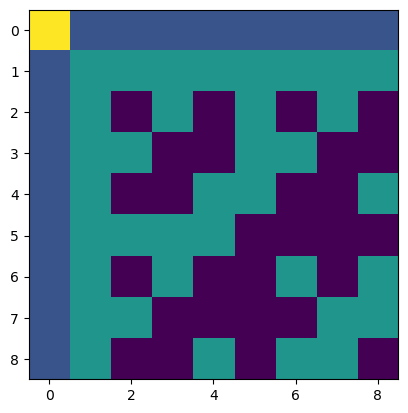


Total number of candidate sequences: 5040
Total candidate sequences with fixed prefix: 144

Starting global search over all candidate sequences...
[(0, 2), (0, 5), (0, 3), (0, 8), (0, 1), (0, 4), (0, 6), (0, 7), (0, 6), (0, 4), (0, 1), (0, 8), (0, 3), (0, 5), (0, 2)]
[1.         0.34074847 0.5        0.4702964  0.39182655 0.08657066
 0.33333333 0.0161498  0.29516724 0.64046438 0.26772047 1.40288438
 0.24675171 1.55756396 0.23005346 0.81794572 0.24675171 1.78072076
 0.26772047 0.71125897 0.29516724 1.57242575 0.33333333 1.89874822
 0.39182655 1.41218696 0.5        1.59113677 1.         1.05016327]
2.218318428565258
[1.         0.92646287 0.5        1.51970014 0.39182655 0.49834467
 0.33333333 0.81446681 0.29516724 1.64597823 0.26772047 1.95993556
 0.24675171 0.80860496 0.23005346 0.53796882 0.24675171 1.91280211
 0.26772047 1.94171707 0.29516724 1.13725407 0.33333333 1.25948922
 0.39182655 1.12892377 0.5        1.59922076 1.         1.76896958]
1.8747582869552313
[1.         0.28919974

In [80]:
import numpy as np
import itertools
from scipy.linalg import expm
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
###########################################
# Part 1: Build and output the target unitary
###########################################

dim = 9

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi):
    theta = np.pi * f      # rotation angle = π * f
    phi_rad = np.pi * phi  # effective phase in radians
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    # Using the 0.5 factor in the pulse Hamiltonian (as in your original code)
    U = expm(-1j * 0.5 * H * theta)
    return U

def canonicalize(coupling, phase_flag):
    """Convert a pulse to canonical form: if given as (i,0) with i != 0, swap to (0,i)
       and add 1.0 to the phase flag."""
    i, j = coupling
    if i != 0 and j == 0:
        return (0, i), phase_flag + 1.0
    else:
        return coupling, phase_flag

# --- Define the full (original) pulse list in canonical form for dim=9 ---
couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)]  +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)] +
                  [(6,0),(0,5),(6,0)] +
                  [(8,0),(7,0)]  +
                  [(0,5),(7,0)] +
                  [(6,0)] +
                  [(0,2),(6,0)] +
                  [(5,0),(0,1),(5,0)] +
                  [(7,0),(0,3),(7,0)] +
                  [(0,4),(8,0)])

fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2, 1] +
                  [1/2, 1])

fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5])

# Build the canonical pulse list.
pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

# Compute the target unitary by applying the pulses in order.
U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph)
    U_target = U_pulse @ U_target

# Remove the overall global phase by normalizing the determinant.
U_target = U_target / np.linalg.det(U_target)

print("Target Unitary (rounded):")
print(np.round(U_target, 3))
plt.imshow(np.real(U_target))
plt.show()
###########################################
# Part 2: Global Search Over All Candidate Sequences
###########################################

# --- Functions for continuous parameter optimization for a candidate sequence ---
def candidate_unitary(seq, x):
    """
    Given a candidate sequence (list of couplings) and a parameter vector x (length 2*k),
    where for each pulse: x[2*i] = fraction f and x[2*i+1] = phase phi,
    compute the overall candidate unitary.
    """
    U = np.eye(dim, dtype=complex)
    k = len(seq)
    for i in range(k):
        f = x[2*i]
        phi = x[2*i+1]
        # phi = x[2*i+1]
        U_i = pulse_operator(seq[i], f, phi)
        U = U_i @ U
    return U

def optimal_global_phase(U, U_target):
    """
    Compute the global phase that minimizes the difference between U and U_target.
    """
    theta_opt = np.angle(np.trace(U @ np.conjugate(U_target).T))
    return theta_opt

def cost_function(x, seq, U_target):
    """
    Cost function: the Frobenius norm difference between the candidate unitary
    (after optimal global phase adjustment) and U_target.
    """
    U = candidate_unitary(seq, x)
    theta_opt = optimal_global_phase(U, U_target)
    U_adjusted = np.exp(-1j * theta_opt) * U
    return np.linalg.norm(U_adjusted - U_target, ord='fro')

# --- Construct all candidate sequences according to your rules ---
def all_candidate_sequences(distinct_couplings):

    left_side = distinct_couplings[:-1]  # first 7 couplings
    center = distinct_couplings[-1]      # center coupling (here, (0,8))
    
    candidates = []
    for perm in itertools.permutations(left_side):
        candidate_seq = list(perm) + [center] + list(reversed(perm))
        candidates.append(candidate_seq)
    return candidates

# For dim=9, we assume these are the distinct couplings in canonical form:
distinct_couplings = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8)]
all_candidates = all_candidate_sequences(distinct_couplings)
print("\nTotal number of candidate sequences:", len(all_candidates))
# (This should be 7! = 5040 candidate sequences)

# --- Global search: loop over all candidate sequences ---
k = 15  # Each candidate sequence has 15 pulses.
threshold = 1e-6
best_seq_overall = None
best_params_overall = None
best_cost_overall = np.inf

num_trials = 3  # number of random initial guesses per candidate sequence

import itertools

# Fixed prefix for the left side:
fixed_prefix = []
# The remaining couplings for the left side (from the 7 available):
remaining = [(0, 2),(0, 5), (0, 6), (0, 7), (0, 1), (0, 4), (0, 3)]
ll_prefix = [(0, 2),(0, 5), (0, 3), (0, 8)]
l_prefix = [(0, 1), (0, 4), (0, 6)]
# man_seq = [[(0, 2),(0, 3), (0, 5), (0, 8), (0, 1), (0, 4), (0, 6)]]
candidate_sequences = []
for perm_ll in itertools.permutations(ll_prefix):
    for perm_l in itertools.permutations(l_prefix):
        left_side = fixed_prefix + list(perm_ll) + list(perm_l) # Left side now has 7 couplings
        center = (0, 7)                        
        right_side = list(reversed(left_side)) 
        candidate_seq = left_side + [center] + right_side
        candidate_sequences.append(candidate_seq)

print("Total candidate sequences with fixed prefix:", len(candidate_sequences))
# for seq in candidate_sequences:
#     print(seq)


print("\nStarting global search over all candidate sequences...")
start_time = time.time()
count = 0
found = False
np.random.shuffle(all_candidates)
cs = [[(0, 2), (0, 5), (0, 3), (0, 8), (0, 1), (0, 4), (0, 6), (0, 7), (0, 6), (0, 4), (0, 1), (0, 8), (0, 3), (0, 5), (0, 2)]]
for candidate_seq in cs:
    count += 1
    # Optionally, you can print progress every 100 candidates:
    fractions = [1.0, 0.5000000000000001, 0.3918265520306073, 0.33333333333333337, 0.2951672353008665, 0.26772047280123, 0.24675171442884983, 0.2300534561626159, 0.24675171442884983, 0.26772047280123, 0.2951672353008665, 0.33333333333333337, 0.3918265520306073, 0.5000000000000001, 1.0]

    print(candidate_seq)
    if count % 100 == 0:
        print(f"Candidate {count} / {len(all_candidates)}; current best cost: {best_cost_overall:.2e}")
    
    for trial in range(num_trials):
        # Initialize 2*k parameters: fraction in [0,1] and phase in [0,2]
        x0 = []
        for i in range(k):
            # x0.append(np.random.uniform(0, 2))
            x0.append(fractions[i])
            x0.append(np.random.uniform(0, 2))
        x0 = np.array(x0)
        print(x0)
        # Define bounds: fraction in [0,1.5] and phase in [0,2]
        bounds = []
        for i in range(k):
            bounds.append((0, 4))
            bounds.append((0, 4))
        res = minimize(cost_function, x0, args=(candidate_seq, U_target),
                       method='L-BFGS-B', bounds=bounds,
                       options={'ftol': 1e-8, 'gtol': 1e-8, 'maxiter':1000000})
        if res.success:
            cost_val = res.fun
            print(cost_val)
            if cost_val < best_cost_overall:
                best_cost_overall = cost_val
                best_seq_overall = candidate_seq
                best_params_overall = res.x
                # If below threshold, we consider it solved.
                if best_cost_overall < threshold:
                    found = True
                    break
    if found:
        print(f"Candidate sequence #{count} achieved cost {best_cost_overall:.2e} (< threshold).")
        break

end_time = time.time()
print(f"\nGlobal search completed in {end_time - start_time:.1f} seconds.")

if best_seq_overall is not None:
    print("\nOptimized candidate sequence (couplings):")
    print(best_seq_overall)
    print("\nOptimized parameters (per pulse):")
    for i, coupling in enumerate(best_seq_overall):
        f_val = best_params_overall[2*i]
        phi_val = best_params_overall[2*i+1]
        print(f"Pulse {i+1}: coupling = {coupling}, fraction = {f_val:.4f}, phase = {phi_val:.4f}")
    
    U_optimized = candidate_unitary(best_seq_overall, best_params_overall)
    theta_opt = optimal_global_phase(U_optimized, U_target)
    U_adjusted = np.exp(-1j*theta_opt) * U_optimized
    print("\nTarget unitary (rounded):")
    print(np.round(U_target, 3))
    print("\nOptimized candidate sequence unitary (rounded):")
    print(np.round(U_adjusted, 3))
    print(f"\nBest cost: {best_cost_overall:.2e}")
else:
    print("No candidate sequence was found that approximates the target unitary within the threshold.")


Target Unitary (rounded):
[[ 1.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.354+0.j  0.354-0.j  0.354-0.j  0.354-0.j  0.354-0.j
   0.354-0.j  0.354-0.j  0.354-0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j  0.354-0.j -0.354+0.j  0.354+0.j
  -0.354+0.j  0.354-0.j -0.354+0.j]
 [ 0.   +0.j  0.354+0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j
   0.354-0.j -0.354+0.j -0.354+0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j  0.354+0.j
  -0.354+0.j -0.354+0.j  0.354-0.j]
 [ 0.   +0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j -0.354-0.j
  -0.354+0.j -0.354+0.j -0.354+0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j  0.354+0.j -0.354-0.j -0.354-0.j
   0.354+0.j -0.354-0.j  0.354+0.j]
 [ 0.   +0.j  0.354+0.j  0.354+0.j -0.354-0.j -0.354-0.j -0.354-0.j
  -0.354-0.j  0.354+0.j  0.354+0.j]
 [ 0.   +0.j  0.354+0.j -0.354-0.j -0.354-0.j  0.354+0.j -0.354-0.j
   0.354+0.j  0.354+0.j -0.354-0.j]]


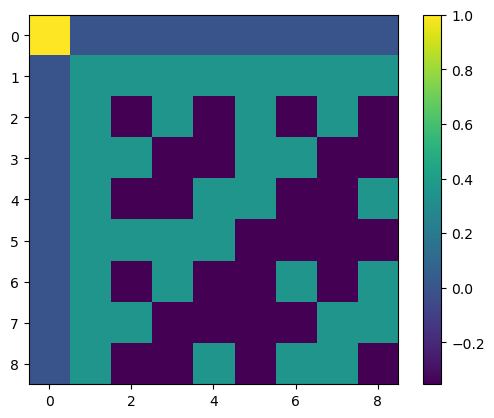

Total candidate sequences with fixed prefix: 144

Starting global search over candidate sequences...

Candidate sequence:
[(0, 2), (0, 5), (0, 3), (0, 8), (0, 1), (0, 4), (0, 6), (0, 7), (0, 6), (0, 4), (0, 1), (0, 8), (0, 3), (0, 5), (0, 2)]
Differential Evolution cost: 1.95e+00

Candidate sequence:
[(0, 2), (0, 5), (0, 3), (0, 8), (0, 1), (0, 6), (0, 4), (0, 7), (0, 4), (0, 6), (0, 1), (0, 8), (0, 3), (0, 5), (0, 2)]
Differential Evolution cost: 1.95e+00

Candidate sequence:
[(0, 2), (0, 5), (0, 3), (0, 8), (0, 4), (0, 1), (0, 6), (0, 7), (0, 6), (0, 1), (0, 4), (0, 8), (0, 3), (0, 5), (0, 2)]
Differential Evolution cost: 1.87e+00

Candidate sequence:
[(0, 2), (0, 5), (0, 3), (0, 8), (0, 4), (0, 6), (0, 1), (0, 7), (0, 1), (0, 6), (0, 4), (0, 8), (0, 3), (0, 5), (0, 2)]
Differential Evolution cost: 2.03e+00

Candidate sequence:
[(0, 2), (0, 5), (0, 3), (0, 8), (0, 6), (0, 1), (0, 4), (0, 7), (0, 4), (0, 1), (0, 6), (0, 8), (0, 3), (0, 5), (0, 2)]
Differential Evolution cost: 2.00e+00

KeyboardInterrupt: 

In [53]:
import numpy as np
import itertools
from scipy.linalg import expm
from scipy.optimize import minimize, differential_evolution, basinhopping
import time
import matplotlib.pyplot as plt

###########################################
# Part 1: Build and output the target unitary
###########################################

dim = 9

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi):
    theta = np.pi * f      # rotation angle = π * f
    phi_rad = np.pi * phi  # effective phase in radians
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    # Using the 0.5 factor in the pulse Hamiltonian
    U = expm(-1j * 0.5 * H * theta)
    return U

def canonicalize(coupling, phase_flag):
    """Convert a pulse to canonical form: if given as (i,0) with i != 0, swap to (0,i)
       and add 1.0 to the phase flag."""
    i, j = coupling
    if i != 0 and j == 0:
        return (0, i), phase_flag + 1.0
    else:
        return coupling, phase_flag

# --- Define the full (original) pulse list in canonical form for dim=9 ---
couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)]  +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)] +
                  [(6,0),(0,5),(6,0)] +
                  [(8,0),(7,0)]  +
                  [(0,5),(7,0)] +
                  [(6,0)] +
                  [(0,2),(6,0)] +
                  [(5,0),(0,1),(5,0)] +
                  [(7,0),(0,3),(7,0)] +
                  [(0,4),(8,0)])

fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2, 1] +
                  [1/2, 1])

fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5])

# Build the canonical pulse list.
pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

# Compute the target unitary by applying the pulses in order.
U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph)
    U_target = U_pulse @ U_target

# Remove the overall global phase by normalizing the determinant.
U_target = U_target / np.linalg.det(U_target)

print("Target Unitary (rounded):")
print(np.round(U_target, 3))
plt.imshow(np.real(U_target))
plt.colorbar()
plt.show()

###########################################
# Part 2: Global Search Over All Candidate Sequences
###########################################

# --- Functions for continuous parameter optimization for a candidate sequence ---
def candidate_unitary(seq, x):
    """
    Given a candidate sequence (list of couplings) and a parameter vector x (length 2*k),
    where for each pulse: x[2*i] = fraction f and x[2*i+1] = phase phi,
    compute the overall candidate unitary.
    """
    U = np.eye(dim, dtype=complex)
    k = len(seq)
    for i in range(k):
        f = x[2*i]
        phi = x[2*i+1]
        U_i = pulse_operator(seq[i], f, phi)
        U = U_i @ U
    return U

def optimal_global_phase(U, U_target):
    """
    Compute the global phase that minimizes the difference between U and U_target.
    """
    theta_opt = np.angle(np.trace(U @ np.conjugate(U_target).T))
    return theta_opt

def cost_function(x, seq, U_target):
    """
    Cost function: the Frobenius norm difference between the candidate unitary
    (after optimal global phase adjustment) and U_target.
    """
    U = candidate_unitary(seq, x)
    theta_opt = optimal_global_phase(U, U_target)
    U_adjusted = np.exp(-1j * theta_opt) * U
    return np.linalg.norm(U_adjusted - U_target, ord='fro')

# --- Construct candidate sequences ---
# Here we build a set of candidate sequences with a fixed prefix (adjust as needed)
fixed_prefix = []
ll_prefix = [(0, 2), (0, 5), (0, 3), (0, 8)]
l_prefix = [(0, 1), (0, 4), (0, 6)]
candidate_sequences = []
for perm_ll in itertools.permutations(ll_prefix):
    for perm_l in itertools.permutations(l_prefix):
        left_side = fixed_prefix + list(perm_ll) + list(perm_l)  # left side now has 7 couplings
        center = (0, 7)
        right_side = list(reversed(left_side))
        candidate_seq = left_side + [center] + right_side
        candidate_sequences.append(candidate_seq)

print("Total candidate sequences with fixed prefix:", len(candidate_sequences))

###########################################
# Global search using multiple optimization methods
###########################################

k = 15  # Each candidate sequence has 15 pulses.
threshold = 1e-6
best_seq_overall = None
best_params_overall = None
best_cost_overall = np.inf

num_trials = 30  # number of random initial guesses for L-BFGS-B

# Define parameter bounds: for each pulse, fraction in [0,2] and phase in [0,2]
bounds = []
for i in range(k):
    bounds.append((0, 2))  # fraction
    bounds.append((0, 2))  # phase

print("\nStarting global search over candidate sequences...")
start_time = time.time()
count = 0
found = False

# For demonstration, here we try one candidate sequence (or loop over candidate_sequences)
# You can replace 'cs' with candidate_sequences to try them all.
#cs = [[(0, 2), (0, 5), (0, 3), (0, 8), (0, 1), (0, 4), (0, 6), (0, 7), (0, 6), (0, 4), (0, 1), (0, 8), (0, 3), (0, 5), (0, 2)]]
for candidate_seq in candidate_sequences:
    count += 1
    print("\nCandidate sequence:")
    print(candidate_seq)
    
    # ------------------------------
    # Method 1: L-BFGS-B (local minimization)
    # ------------------------------
    # for trial in range(num_trials):
    #     # Random initialization for 2*k parameters
    #     x0 = np.array([np.random.uniform(0, 2) for _ in range(2*k)])
    #     res_lbfgsb = minimize(cost_function, x0, args=(candidate_seq, U_target),
    #                             method='L-BFGS-B', bounds=bounds,
    #                             options={'ftol': 1e-12, 'gtol': 1e-12, 'maxiter': 1000000})
    #     if res_lbfgsb.success:
    #         cost_val = res_lbfgsb.fun
    #         print(f"L-BFGS-B trial {trial+1} cost: {cost_val:.2e}")
    #         if cost_val < best_cost_overall:
    #             best_cost_overall = cost_val
    #             best_seq_overall = candidate_seq
    #             best_params_overall = res_lbfgsb.x
    #             if best_cost_overall < threshold:
    #                 found = True
    #                 break
    # if found:
    #     print(f"Candidate sequence #{count} achieved cost {best_cost_overall:.2e} (< threshold) using L-BFGS-B.")
    #     break

    # ------------------------------
    # Method 2: Differential Evolution (global optimizer)
    # ------------------------------
    res_de = differential_evolution(lambda x: cost_function(x, candidate_seq, U_target),
                                      bounds=bounds, maxiter=100000, tol=1e-12, polish=True)
    if res_de.success:
        cost_val_de = res_de.fun
        print(f"Differential Evolution cost: {cost_val_de:.2e}")
        if cost_val_de < best_cost_overall:
            best_cost_overall = cost_val_de
            best_seq_overall = candidate_seq
            best_params_overall = res_de.x
            if best_cost_overall < threshold:
                found = True
                break

    # ------------------------------
    # Method 3: Basin Hopping (global optimizer)
    # ------------------------------
    # x0_bh = np.array([np.random.uniform(0, 2) for _ in range(2*k)])
    # minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds,
    #                     "options": {'ftol': 1e-19, 'gtol': 1e-19, 'maxiter': 1000000}}
    # res_bh = basinhopping(lambda x: cost_function(x, candidate_seq, U_target),
    #                        x0_bh, minimizer_kwargs=minimizer_kwargs, niter=100, disp=False)
    # if res_bh.lowest_optimization_result.success:
    #     cost_val_bh = res_bh.fun
    #     print(f"Basin Hopping cost: {cost_val_bh:.2e}")
    #     if cost_val_bh < best_cost_overall:
    #         best_cost_overall = cost_val_bh
    #         best_seq_overall = candidate_seq
    #         best_params_overall = res_bh.x
    #         if best_cost_overall < threshold:
    #             found = True
    #             break

    if found:
        print(f"Candidate sequence #{count} achieved cost {best_cost_overall:.2e} (< threshold).")
        break

end_time = time.time()
print(f"\nGlobal search completed in {end_time - start_time:.1f} seconds.")

if best_seq_overall is not None:
    print("\nOptimized candidate sequence (couplings):")
    print(best_seq_overall)
    print("\nOptimized parameters (per pulse):")
    for i, coupling in enumerate(best_seq_overall):
        f_val = best_params_overall[2*i]
        phi_val = best_params_overall[2*i+1]
        print(f"Pulse {i+1}: coupling = {coupling}, fraction = {f_val:.4f}, phase = {phi_val:.4f}")
    
    U_optimized = candidate_unitary(best_seq_overall, best_params_overall)
    theta_opt = optimal_global_phase(U_optimized, U_target)
    U_adjusted = np.exp(-1j*theta_opt) * U_optimized
    print("\nTarget unitary (rounded):")
    print(np.round(U_target, 3))
    print("\nOptimized candidate sequence unitary (rounded):")
    print(np.round(U_adjusted, 3))
    print(f"\nBest cost: {best_cost_overall:.2e}")
else:
    print("No candidate sequence was found that approximates the target unitary within the threshold.")


In [75]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import minimize

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * f
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        H_op = coupling_operator_with_phase(i, j, dim, phi_fixed)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def loss_function(x, couplings, fixed_phase_flags, dim, target):
    fractions = x[:len(couplings)]
    # print(len(fractions))
    # fixed_phase_flags = x[len(couplings):]
    # print(len(fixed_phase_flags))
    rabi_freqs = [1.0] * len(fractions)
    U_trial = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
    return norm(target - U_trial)

# Define target unitary
target = np.array([
    [ 1. -0.j,  0. -0.j, -0. -0.j,  0. -0.j, -0. +0.j],
    [ 0. +0.j,  0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
    [-0. +0.j,  0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
    [ 0. +0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
    [ 0. +0.j,  0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
], dtype=complex)

# Parameters
dim = 5
couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
initial_fractions = [1] * 2*len(couplings)
# Run optimizer
result = minimize(loss_function, initial_fractions, args=(couplings, fixed_phase_flags, dim, target),
                  bounds=[(0, 2)]*2*len(couplings), method='L-BFGS-B')

optimized_fractions = result.x
rabi_freqs = [1.0] * len(couplings)
U_optimized = unitary(couplings, rabi_freqs, optimized_fractions, fixed_phase_flags, dim)

# Compute fidelity and error
fidelity = np.abs(np.trace(np.conj(target.T) @ U_optimized)) / dim
error = norm(target - U_optimized)

print("Optimized Couplings:", couplings)
print("Optimized Fractions:", optimized_fractions)
print("Fixed Phase Flags: ", fixed_phase_flags)
print("Fidelity: ", fidelity)
print("Error: ", error)



Optimized Couplings: [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
Optimized Fractions: [1.         1.5        0.39182655 0.66666666 0.39182655 0.49999999
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
Fixed Phase Flags:  [0, 1, 0, 1, 0, 1, 1]
Fidelity:  1.0
Error:  2.639829416768269e-08


In [39]:
import numpy as np
import itertools
from scipy.linalg import expm
from scipy.optimize import minimize
import time

###########################################
# Part 1: Build and Output the Target Unitary
###########################################

dim = 5

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Returns the coupling operator between levels i and j with phase phi (radians).
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi):
    """
    Returns the pulse operator for a pulse with:
      - coupling: a tuple (i,j),
      - f: fraction (rotation angle = π*f),
      - phi: effective phase (will be multiplied by π).
    Uses a 0.5 factor in the Hamiltonian as in your original code.
    """
    theta = np.pi * f       # rotation angle
    phi_rad = np.pi * phi   # effective phase in radians
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    U = expm(-1j * 0.5 * H * theta)
    return U

def canonicalize(coupling, phase_flag):
    """
    If a coupling is given as (i,0) with i != 0, swap it to (0,i) and add 1.0 to phase_flag.
    """
    i, j = coupling
    if i != 0 and j == 0:
        return (0, i), phase_flag + 1.0
    else:
        return coupling, phase_flag

# Provided parameters for the target unitary:
couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)] +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)])
fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1])
fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5])

# Build canonical pulse list.
pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

# Compute the target unitary by applying pulses in sequence.
U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph)
    U_target = U_pulse @ U_target

# Normalize to remove global phase.
U_target = U_target / np.linalg.det(U_target)

print("Target Unitary (rounded):")
print(np.round(U_target, 3))


###########################################
# Part 2: Global Search Over All Candidate Sequences
###########################################

# For dim=5, the allowed transitions from level 0 are:
# (0,1), (0,2), (0,3), (0,4)
# These are the distinct couplings (note: from the target pulses we got 4 distinct ones).
distinct_couplings = [(0,3), (0,2), (0,1)]

# Candidate sequence construction:
def all_candidate_sequences(distinct_couplings):
    """
    Generate all candidate sequences under the conditions:
      - Left side: a permutation of the first (n-1) couplings from distinct_couplings.
      - Center: the last coupling.
      - Right side: mirror (reverse) of the left side.
    For n = 4 distinct couplings, each candidate sequence has 2*(4-1)+1 = 7 couplings.
    """
    left_side = distinct_couplings[:-1]  # first 3 couplings
    center = distinct_couplings[-1]       # the last coupling, i.e. (0,4)
    candidates = []
    for perm in itertools.permutations(left_side):
        candidate_seq = list(perm) + [center] + list(reversed(perm))
        candidates.append(candidate_seq)
    return candidates

all_candidates = all_candidate_sequences(distinct_couplings)
print("\nTotal number of candidate sequences:", len(all_candidates))
# (Should be 3! = 6 candidate sequences)

# In our candidate search we let the continuous parameter for fraction f remain continuous,
# but we force the phase parameter to be discrete: its value is 0 if < 0.5, else 1.
def candidate_unitary(seq, x):
    """
    For a candidate sequence (list of couplings) and parameter vector x (length 2*k)
    where for each pulse: x[2*i] = fraction f (continuous) and
    x[2*i+1] is interpreted discretely: 0 if <0.5, else 1.
    """
    U = np.eye(dim, dtype=complex)
    k = len(seq)
    for i in range(k):
        f = x[2*i]
        phi = 0 if x[2*i+1] < 0.5 else 1
        U_i = pulse_operator(seq[i], f, phi)
        U = U_i @ U
    return U

def optimal_global_phase(U, U_target):
    theta_opt = np.angle(np.trace(U @ np.conjugate(U_target).T))
    return theta_opt

def cost_function(x, seq, U_target):
    U = candidate_unitary(seq, x)
    theta_opt = optimal_global_phase(U, U_target)
    U_adjusted = np.exp(-1j * theta_opt) * U
    return np.linalg.norm(U_adjusted - U_target, ord='fro')

# Global search settings:
k = 7  # candidate sequence length (for 4 distinct couplings: 2*(4-1)+1=7)
threshold = 1e-6
best_seq_overall = None
best_params_overall = None
best_cost_overall = np.inf

num_trials = 30  # number of random initializations per candidate sequence

print("\nStarting global search over all candidate sequences (phases fixed to 0 or 1)...")
start_time = time.time()
count = 0
found = False

for candidate_seq in all_candidates[::-1]:
    count += 1
    # Print progress every candidate.
    print(f"Trying candidate sequence {count} / {len(all_candidates)}; current best cost: {best_cost_overall:.2e}")
    
    for trial in range(num_trials):
        # x has 2*k parameters. For each pulse: fraction in [0,1.5], phase parameter in [0,1].
        x0 = []
        for i in range(k):
            x0.append(np.random.uniform(0, 2))   # fraction f
            x0.append(np.random.uniform(0, 1))   # phase parameter (interpreted discretely)
        x0 = np.array(x0)
        bounds = []
        for i in range(k):
            bounds.append((0, 2))
            bounds.append((0, 1))
            
        res = minimize(cost_function, x0, args=(candidate_seq, U_target),
                       method='L-BFGS-B', bounds=bounds,
                       options={'ftol': 1e-8, 'gtol': 1e-8, 'maxiter': 10000})
        if res.success:
            cost_val = res.fun
            if cost_val < best_cost_overall:
                best_cost_overall = cost_val
                best_seq_overall = candidate_seq
                best_params_overall = res.x
                if best_cost_overall < threshold:
                    found = True
                    break
    if found:
        print(f"Candidate sequence #{count} achieved cost {best_cost_overall:.2e} (< threshold).")
        break

end_time = time.time()
print(f"\nGlobal search completed in {end_time - start_time:.1f} seconds.")

if best_seq_overall is not None:
    print("\nOptimized candidate sequence (couplings):")
    print(best_seq_overall)
    print("\nOptimized parameters (per pulse):")
    for i, coupling in enumerate(best_seq_overall):
        f_val = best_params_overall[2*i]
        phi_val = 0 if best_params_overall[2*i+1] < 0.5 else 1
        print(f"Pulse {i+1}: coupling = {coupling}, fraction = {f_val:.4f}, phase = {phi_val}")
    
    U_optimized = candidate_unitary(best_seq_overall, best_params_overall)
    theta_opt = optimal_global_phase(U_optimized, U_target)
    U_adjusted = np.exp(-1j * theta_opt) * U_optimized
    print("\nTarget Unitary (rounded):")
    print(np.round(U_target, 3))
    print("\nOptimized Candidate Sequence Unitary (rounded):")
    print(np.round(U_adjusted, 3))
    print(f"\nBest cost: {best_cost_overall:.2e}")
else:
    print("No candidate sequence was found that approximates the target unitary within the threshold.")


Target Unitary (rounded):
[[ 1. -0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5-0.j  0.5-0.j  0.5-0.j  0.5-0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5-0.j -0.5+0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5-0.j -0.5+0.j  0.5-0.j]]

Total number of candidate sequences: 6

Starting global search over all candidate sequences (phases fixed to 0 or 1)...
Trying candidate sequence 1 / 6; current best cost: inf
Trying candidate sequence 2 / 6; current best cost: 1.08e+00
Candidate sequence #2 achieved cost 3.00e-08 (< threshold).

Global search completed in 7.2 seconds.

Optimized candidate sequence (couplings):
[(0, 2), (0, 3), (0, 4), (0, 1), (0, 4), (0, 3), (0, 2)]

Optimized parameters (per pulse):
Pulse 1: coupling = (0, 2), fraction = 1.0000, phase = 0
Pulse 2: coupling = (0, 3), fraction = 1.5000, phase = 1
Pulse 3: coupling = (0, 4), fraction = 0.3918, phase = 1
Pulse 4: coupling = (0, 1), fraction = 0.6667, phase = 0
Pulse 5: coupling = (0, 4), fra

In [41]:
U1 = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)]
cs = U1+[(0, 1)]+U1[::-1]

# U1 = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 6), (0, 7), (0, 5)]
# cs = U1+[(0, 8)]+U1[::-1]
print(cs)

[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 1), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2)]


In [62]:
fractions = []
for i in range(8):
    print(i)
    fractions.append(2.0 * np.arcsin(np.sqrt(1/(i+1)))/np.pi)

fractions_structure = list(fractions[:-1]) + list([fractions[-1]]) + list(fractions[:-1][::-1])
print(fractions_structure)

0
1
2
3
4
5
6
7
[1.0, 0.5000000000000001, 0.3918265520306073, 0.33333333333333337, 0.2951672353008665, 0.26772047280123, 0.24675171442884983, 0.2300534561626159, 0.24675171442884983, 0.26772047280123, 0.2951672353008665, 0.33333333333333337, 0.3918265520306073, 0.5000000000000001, 1.0]


In [54]:
fractions = list(fractions[:-1]) + list([fractions[-1]]) + list(fractions[:-1][::-1])

SyntaxError: unmatched ')' (3060348474.py, line 1)

In [55]:
2.0 * np.arcsin(np.sqrt(1/2))/np.pi

0.5000000000000001

Tried 0 candidates. Best fidelity so far: 0.214378
Tried 10 candidates. Best fidelity so far: 0.344661
Tried 20 candidates. Best fidelity so far: 0.344661
Tried 30 candidates. Best fidelity so far: 0.351329
Tried 40 candidates. Best fidelity so far: 0.365673
Tried 50 candidates. Best fidelity so far: 0.365673
Tried 60 candidates. Best fidelity so far: 0.368733
Tried 70 candidates. Best fidelity so far: 0.388129
Tried 80 candidates. Best fidelity so far: 0.402584
Tried 90 candidates. Best fidelity so far: 0.402584
Tried 100 candidates. Best fidelity so far: 0.402584
Tried 110 candidates. Best fidelity so far: 0.402584
Tried 120 candidates. Best fidelity so far: 0.402584
Tried 130 candidates. Best fidelity so far: 0.402584
Tried 140 candidates. Best fidelity so far: 0.402584
Tried 150 candidates. Best fidelity so far: 0.402584
Tried 160 candidates. Best fidelity so far: 0.402584
Tried 170 candidates. Best fidelity so far: 0.402584
Tried 180 candidates. Best fidelity so far: 0.402584
Trie

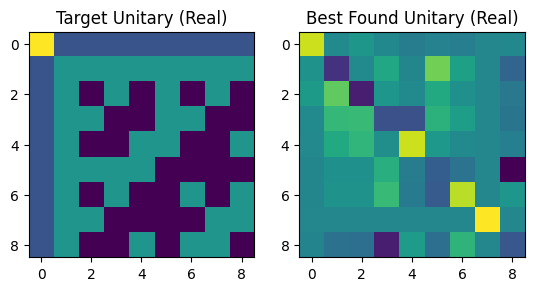

In [66]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import itertools

# --- Utilities ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi, dim):
    theta = np.pi * f
    phi_rad = np.pi * phi
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    U = expm(-1j * 0.5 * H * theta)
    return U

def expected_fraction_structure():
    fractions = []
    for i in range(8):
        fractions.append(2.0 * np.arcsin(np.sqrt(1/(i+1))) / np.pi)
    return list(fractions[:-1]) + [fractions[-1]] + list(fractions[:-1][::-1])

def all_candidate_sequences(distinct_couplings):
    left_side = distinct_couplings[:-1]  # first 7 couplings
    center = distinct_couplings[-1]      # center coupling (here, (0,8))

    candidates = []
    for perm in itertools.permutations(left_side):
        candidate_seq = list(perm) + [center] + list(reversed(perm))
        candidates.append(candidate_seq)
    return candidates

# --- Loss Function ---
def loss_function(x, couplings, dim, target, lambda_structure=5.0):
    n_couplings = len(couplings)
    fractions = x[:n_couplings]
    phase_flags = x[n_couplings:]

    U_seq = np.eye(dim, dtype=complex)
    for (levels, f, phase_flag) in zip(couplings, fractions, phase_flags):
        U_pulse = pulse_operator(levels, f, phase_flag, dim)
        U_seq = U_pulse @ U_seq

    loss1 = norm(target - U_seq)

    fitted_fracs_mod = np.array([(frac if frac <=1 else frac-1) for frac in fractions])
    expected_fracs = np.array(expected_fraction_structure())
    loss2 = norm(fitted_fracs_mod - expected_fracs)

    return loss1 + lambda_structure * loss2

# --- Setup ---
dim = 9

# Define distinct couplings
distinct_couplings = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8)]
candidate_couplings_list = all_candidate_sequences(distinct_couplings)

# Define your target unitary
# Build canonical pulse list
def canonicalize(coupling, phase_flag):
    i, j = coupling
    if i != 0 and j == 0:
        return (0, i), phase_flag + 1.0
    else:
        return coupling, phase_flag

couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)]  +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)] +
                  [(6,0),(0,5),(6,0)] +
                  [(8,0),(7,0)]  +
                  [(0,5),(7,0)] +
                  [(6,0)] +
                  [(0,2),(6,0)] +
                  [(5,0),(0,1),(5,0)] +
                  [(7,0),(0,3),(7,0)] +
                  [(0,4),(8,0)])

fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2, 1] +
                  [1/2, 1])

fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5])

pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph, dim)
    U_target = U_pulse @ U_target

# Remove overall global phase
target = U_target / np.linalg.det(U_target)

# --- Search over candidate couplings ---
best_fidelity = 0
best_result = None
best_candidate = None

for idx, candidate_couplings in enumerate(candidate_couplings_list[::-1]):
    np.random.seed(42 + idx)
    initial_fractions = np.random.uniform(0, 2, size=len(candidate_couplings))
    initial_phases = np.random.uniform(0, 2, size=len(candidate_couplings))
    initial_guess = np.concatenate([initial_fractions, initial_phases])

    bounds = [(0, 2)] * (2 * len(candidate_couplings))

    result = minimize(loss_function, initial_guess, args=(candidate_couplings, dim, target, 5.0),
                      bounds=bounds, method='L-BFGS-B')

    optimized_fractions = result.x[:len(candidate_couplings)]
    optimized_phases = result.x[len(candidate_couplings):]

    U_final = np.eye(dim, dtype=complex)
    for (levels, f, phase_flag) in zip(candidate_couplings, optimized_fractions, optimized_phases):
        U_pulse = pulse_operator(levels, f, phase_flag, dim)
        U_final = U_pulse @ U_final

    fidelity = np.abs(np.trace(np.conj(target.T) @ U_final)) / dim

    if fidelity > best_fidelity:
        best_fidelity = fidelity
        best_result = (optimized_fractions, optimized_phases)
        best_candidate = candidate_couplings

    if idx % 10 == 0:
        print(f"Tried {idx} candidates. Best fidelity so far: {best_fidelity:.6f}")

# --- Final Result ---
print("\nBest Couplings:", best_candidate)
print("Optimized Fractions:", best_result[0])
print("Optimized Phase Flags:", best_result[1])
print("Best Fidelity:", best_fidelity)

# Plot real part of target vs optimized
U_best = np.eye(dim, dtype=complex)
for (levels, f, phase_flag) in zip(best_candidate, best_result[0], best_result[1]):
    U_pulse = pulse_operator(levels, f, phase_flag, dim)
    U_best = U_pulse @ U_best

plt.figure()
plt.subplot(1,2,1)
plt.title("Target Unitary (Real)")
plt.imshow(np.real(target))

plt.subplot(1,2,2)
plt.title("Best Found Unitary (Real)")
plt.imshow(np.real(U_best))
plt.show()


Optimized Couplings: [(0, 3), (0, 5), (0, 2), (0, 8), (0, 6), (0, 8), (0, 4), (0, 5), (0, 1), (0, 2), (0, 7), (0, 1), (0, 4), (0, 4), (0, 3)]
Optimized Fractions: [0.99999872 0.40314629 0.67366968 1.23259376 0.57151167 0.32011105
 0.60381992 1.72544292 0.48789905 1.52438392 0.7216277  0.44982418
 0.47517889 0.93933645 1.0000014 ]
Optimized Phases: [1.60948862 1.6094896  1.60949262 1.6094931  0.60949316 1.60949435
 0.60949038 1.60949421 0.60949167 1.60949161 0.60948791 1.60948493
 1.60948094 0.60948302 0.60948971]
Fidelity: 0.7795635563496516
Error: 1.9919477868926223


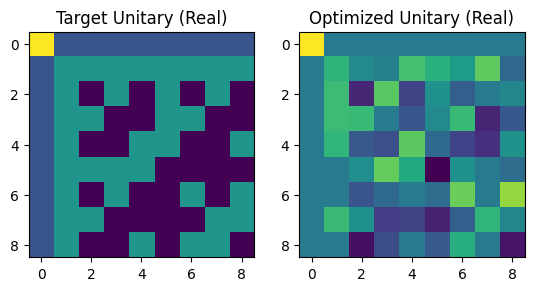

In [69]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt

# --- Utilities ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi, dim):
    theta = np.pi * f
    phi_rad = np.pi * phi
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    U = expm(-1j * 0.5 * H * theta)
    return U

def build_unitary(couplings, fractions, phases, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, f, phase_flag) in zip(couplings, fractions, phases):
        U_pulse = pulse_operator(levels, f, phase_flag, dim)
        U_seq = U_pulse @ U_seq
    return U_seq

# --- Loss Function ---
def loss_function(x, length, dim, target):
    coupling_targets = x[:length]
    fractions = x[length:2*length]
    phases = x[2*length:]

    couplings = [(0, int(np.round(c))) for c in coupling_targets]
    if any(j < 1 or j > 8 for (_, j) in couplings):
        return 1e6  # Large penalty if out of bounds

    U_trial = build_unitary(couplings, fractions, phases, dim)
    loss = norm(target - U_trial)
    return loss

# --- Setup ---
dim = 9

couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)]  +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)] +
                  [(6,0),(0,5),(6,0)] +
                  [(8,0),(7,0)]  +
                  [(0,5),(7,0)] +
                  [(6,0)] +
                  [(0,2),(6,0)] +
                  [(5,0),(0,1),(5,0)] +
                  [(7,0),(0,3),(7,0)] +
                  [(0,4),(8,0)])

fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2, 1] +
                  [1/2, 1])

fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5])

pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph, dim)
    U_target = U_pulse @ U_target

# Remove overall global phase
target = U_target / np.linalg.det(U_target)

# Parameters
length = 15  # You can change this to any length between 10-20

bounds = [(1, 8)] * length + [(0, 2)] * length + [(0, 2)] * length

# --- Simulated Annealing Optimization ---
result = dual_annealing(loss_function, bounds, args=(length, dim, target), maxiter=5000)

# --- Results ---
optimized_couplings_indices = result.x[:length]
optimized_fractions = result.x[length:2*length]
optimized_phases = result.x[2*length:]

optimized_couplings = [(0, int(np.round(c))) for c in optimized_couplings_indices]

U_final = build_unitary(optimized_couplings, optimized_fractions, optimized_phases, dim)

fidelity = np.abs(np.trace(np.conj(target.T) @ U_final)) / dim
error = norm(target - U_final)

print("Optimized Couplings:", optimized_couplings)
print("Optimized Fractions:", optimized_fractions)
print("Optimized Phases:", optimized_phases)
print("Fidelity:", fidelity)
print("Error:", error)

# Plot
plt.figure()
plt.subplot(1,2,1)
plt.title("Target Unitary (Real)")
plt.imshow(np.real(target))

plt.subplot(1,2,2)
plt.title("Optimized Unitary (Real)")
plt.imshow(np.real(U_final))
plt.show()


In [309]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt

# --- Utilities ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi, dim):
    theta = np.pi * f
    phi_rad = np.pi * phi
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    U = expm(-1j * 0.5 * H * theta)
    return U

def build_unitary(couplings, fractions, phases, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, f, phase_flag) in zip(couplings, fractions, phases):
        U_pulse = pulse_operator(levels, f, phase_flag, dim)
        U_seq = U_pulse @ U_seq
    return U_seq

# --- Loss Function ---
def loss_function(x, length, dim, target):
    coupling_targets = x[:length]
    fractions = x[length:2*length]
    phases = x[2*length:]

    couplings = [(0, int(np.round(c))) for c in coupling_targets]
    if any(j < 1 or j > 8 for (_, j) in couplings):
        return 1e6  # Large penalty if out of bounds

    U_trial = build_unitary(couplings, fractions, phases, dim)
    loss = norm(target - U_trial)
    return loss

# --- Setup ---
dim = 9

couplings_orig = ([(2,0),(0,1),(2,0)] +
                  [(4,0),(3,0)]  +
                  [(0,1),(3,0)] +
                  [(0,2),(4,0)] +
                  [(6,0),(0,5),(6,0)] +
                  [(8,0),(7,0)]  +
                  [(0,5),(7,0)] +
                  [(6,0)] +
                  [(0,2),(6,0)] +
                  [(5,0),(0,1),(5,0)] +
                  [(7,0),(0,3),(7,0)] +
                  [(0,4),(8,0)])

fractions_orig = ([1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2] +
                  [1/2, 1] +
                  [1/2] +
                  [1/2, 1] +
                  [1, 1/2, 1] +
                  [1, 1/2, 1] +
                  [1/2, 1])

fixed_phase_flags_orig = ([0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5] +
                          [0.5] +
                          [0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5, 0.5] +
                          [0.5, 0.5])

pulses_full = []
for cpl, frac, ph in zip(couplings_orig, fractions_orig, fixed_phase_flags_orig):
    cpl_fixed, ph_fixed = canonicalize(cpl, ph)
    pulses_full.append((cpl_fixed, frac, ph_fixed))

U_target = np.eye(dim, dtype=complex)
for (cpl, frac, ph) in pulses_full:
    U_pulse = pulse_operator(cpl, frac, ph, dim)
    U_target = U_pulse @ U_target

# Remove overall global phase
target = U_target / np.linalg.det(U_target)

In [311]:
import numpy as np
from scipy.linalg import expm, norm
from scipy.optimize import dual_annealing

# --- YOUR FIXED LIST OF 15 COUPLINGS ---
coupling_list = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 1), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2)]
length = len(coupling_list)  # should be 15
dim = 9

# --- Utilities (unchanged) ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_operator(coupling, f, phi, dim):
    theta = np.pi * f
    phi_rad = np.pi * phi
    H = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi_rad)
    return expm(-1j * 0.5 * H * theta)

def build_unitary(couplings, fractions, phases, dim):
    U = np.eye(dim, dtype=complex)
    for (cpl, frac, ph) in zip(couplings, fractions, phases):
        U = pulse_operator(cpl, frac, ph, dim) @ U
    return U

# --- Precompute your target (unchanged) ---
# … (build U_target exactly as you did, then normalize out global phase) …
# target = U_target / np.linalg.det(U_target)

# --- Loss enforcing a permutation of [0..14] in the first block ---
def loss_function(x, dim, target):
    # 1) Index block → integers 0..14
    idx = np.round(x[:length]).astype(int)
    # 2) Permutation check
    if set(idx) != set(range(length)):
        return 1e6

    # 3) Map indices → couplings
    couplings = [coupling_list[i] for i in idx]
    fractions = x[length:2*length]
    phases    = x[2*length:3*length]

    U_trial = build_unitary(couplings, fractions, phases, dim)
    return norm(target - U_trial)

# --- Bounds for dual_annealing ---
# indices in [0,14], fractions in [0,2], phases in [0,2]
bounds = (
    [(0, length-1)] * length  +   # coupling indices
    [(0, 2)] * length        +   # fractions
    [(0, 2)] * length            # phases
)

# --- Run the optimization ---
result = dual_annealing(
    loss_function,
    bounds,
    args=(dim, target),
    maxiter=5000
)

# --- Unpack the result ---
opt_idx       = np.round(result.x[:length]).astype(int)
opt_couplings = [coupling_list[i] for i in opt_idx]
opt_fracs     = result.x[length:2*length]
opt_phases    = result.x[2*length:3*length]

U_final = build_unitary(opt_couplings, opt_fracs, opt_phases, dim)
fidelity = np.abs(np.trace(target.conj().T @ U_final)) / dim
error    = norm(target - U_final)

print("Optimized coupling order:", opt_couplings)
print("Fractions:", opt_fracs)
print("Phases:", opt_phases)
print("Fidelity:", fidelity)
print("Error:", error)


Optimized coupling order: [(0, 5), (0, 1), (0, 6), (0, 6), (0, 8), (0, 8), (0, 4), (0, 5), (0, 7), (0, 5), (0, 6), (0, 4), (0, 8), (0, 2), (0, 4)]
Fractions: [1.02532178 0.202115   1.91839124 0.88627223 1.57393583 1.26553059
 1.53844473 1.24811219 1.26675293 1.22671007 0.15206335 0.71613332
 0.82614707 0.35413515 0.89512626]
Phases: [0.99169916 1.66473493 0.71301432 1.61043832 1.18257406 1.10059726
 1.05927028 0.99426861 1.76520661 1.22682736 1.80790176 0.55856322
 1.16251126 0.05961689 0.79210566]
Fidelity: 0.012954495382021662
Error: 4.26514770202187
